# <u>HR Analytics Challenge</u>

### Importación de librerías iniciales

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols

#Configure Defaults
import warnings
import os
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = 10,5

In [2]:
def correlation_heatmap(df, method):
    #_ , ax = plt.subplots(figsize =(7,4))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(method=method),
        cmap = colormap,
        square=True, 
        annot=True, 
        annot_kws={'fontsize':9 }
    )
    plt.title('Correlation Matrix', y=1.05, size=15)

Usamos una semilla a lo largo de todo el notebook para los procesos aleatorios

In [3]:
seed = 1000
target = 'is_promoted'
id_column = 'employee_id'

La recomendación para promoción puede tener dos valores: Sí o NO. 

Sí (1): si se recomienda para promoción

No (0): si no se recomienda para promoción

Entonces, al usar el conjunto de datos de entrenamiento, entrenaremos nuestro modelo e intentaremos predecir nuestra columna de destino que es "is_promoted" en el conjunto de datos de prueba.

In [4]:
data_hr_train = pd.read_csv('data/train.csv')
data_hr = pd.read_csv('data/train.csv')


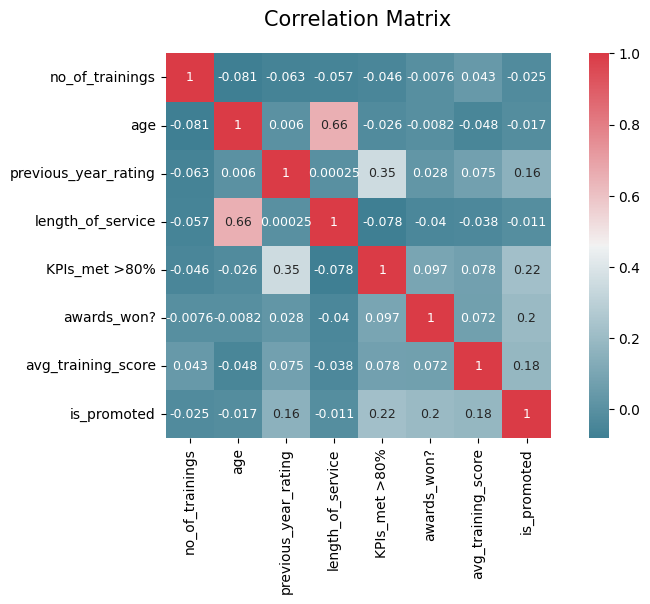

In [5]:
data_hr = data_hr.drop(id_column, axis = 1)
data_hr = data_hr.drop('department', axis = 1)
data_hr = data_hr.drop('region', axis = 1)
correlation_heatmap(data_hr,'pearson')

### 1.EDA

In [6]:
data_hr_train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [7]:
data_hr_train[target].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [8]:
data_target_train = data_hr_train[target]
data_target_train.head()

0    0
1    0
2    0
3    0
4    0
Name: is_promoted, dtype: int64

El id y el target de la tabla no nos va a servir para el entrenamiento de datos, por lo que lo vamos a eliminar el id de los clientes antes de empezar con el tratamiento de datos:

In [9]:
data_hr_train = data_hr_train.drop(id_column, axis = 1)
data_hr_train = data_hr_train.drop(target, axis = 1)

In [10]:
data_hr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   region                54808 non-null  object 
 2   education             52399 non-null  object 
 3   gender                54808 non-null  object 
 4   recruitment_channel   54808 non-null  object 
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  50684 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   KPIs_met >80%         54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 5.0+ MB


In [11]:
data_hr_train.describe() 

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000


In [12]:
data_hr_train.describe(include = 'object')   # para datos categoricos

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


Se descartaron las variables con muchas categorías ( department y region ) .

In [13]:
data_hr_train = data_hr_train.drop('department', axis = 1)
data_hr_train = data_hr_train.drop('region', axis = 1)

In [14]:
data_hr_train['awards_won?'].value_counts(dropna = False)

0    53538
1     1270
Name: awards_won?, dtype: int64

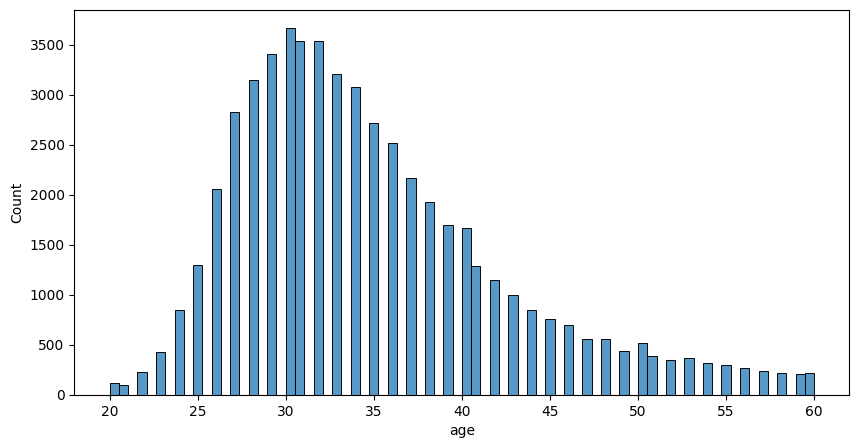

In [15]:
sns.histplot(data = data_hr, x = 'age')
plt.show()

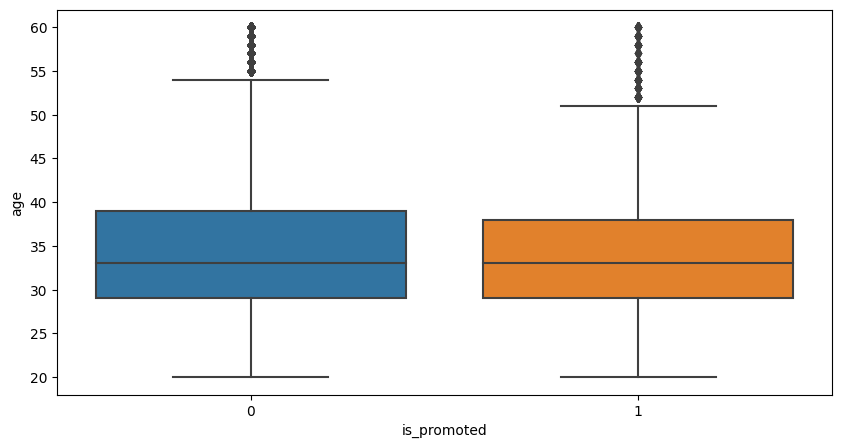

In [16]:
sns.boxplot(data = data_hr, y = 'age', x = target)
plt.show()

#### Tratamiento de nulos

#### Imputación de categóricas

In [19]:
from sklearn.impute import SimpleImputer

data_hr_train_cat = data_hr_train.select_dtypes('object')
data_hr_train_num = data_hr_train.select_dtypes('number')

imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_cat.fit(data_hr_train_cat)
data_hr_train_cat_imputed = pd.DataFrame(imputer_cat.transform(data_hr_train_cat), columns = data_hr_train_cat.columns)

data_hr_train_cat_imputed.head()

,education,gender,recruitment_channel
0,Master's & above,f,sourcing
1,Bachelor's,m,other
2,Bachelor's,m,sourcing
3,Bachelor's,m,other
4,Bachelor's,m,other


In [20]:
imputer_cat.statistics_

array(["Bachelor's", 'm', 'other'], dtype=object)

In [21]:
data_hr_train_cat.isnull().sum()

education              2409
gender                    0
recruitment_channel       0
dtype: int64

In [22]:
data_hr_train_cat_imputed.isnull().sum()

education              0
gender                 0
recruitment_channel    0
dtype: int64

#### Imputación de numéricas

In [23]:
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=3)

In [24]:
# TODO: imputar las variables numéricas con KNN Imputer - interpretar los resultados

knn.fit_transform(data_hr_train_num)

array([[ 1., 35.,  5., ...,  1.,  0., 49.],
       [ 1., 30.,  5., ...,  0.,  0., 60.],
       [ 1., 34.,  3., ...,  0.,  0., 50.],
       ...,
       [ 1., 27.,  5., ...,  1.,  0., 79.],
       [ 1., 29.,  1., ...,  0.,  0., 45.],
       [ 1., 27.,  1., ...,  0.,  0., 49.]])

In [25]:
data_hr_train_num_imputed2 = pd.DataFrame(data = knn.fit_transform(data_hr_train_num), columns = data_hr_train_num.columns)

In [26]:
data_hr_train_num_imputed2.isnull().sum()

no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

### Encoding de variables categóricas

In [27]:
data_hr_train_cat_imputed.describe()

,education,gender,recruitment_channel
count,54808,54808,54808
unique,3,2,3
top,Bachelor's,m,other
freq,39078,38496,30446


In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

ohe.fit(data_hr_train_cat_imputed)

OneHotEncoder()

In [29]:
ohe.categories_

[array(["Bachelor's", 'Below Secondary', "Master's & above"], dtype=object),
 array(['f', 'm'], dtype=object),
 array(['other', 'referred', 'sourcing'], dtype=object)]

In [30]:
ohe.transform(data_hr_train_cat_imputed).toarray()

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [31]:
columnas = list(ohe.categories_[0])+list(ohe.categories_[1])+list(ohe.categories_[2])

In [32]:
data_hr_train_cat_dummies2 = pd.DataFrame(data = ohe.transform(data_hr_train_cat_imputed).toarray(), columns = columnas)

In [33]:
data_hr_train_cat_dummies2.head()

,Bachelor's,Below Secondary,Master's & above,f,m,other,referred,sourcing
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Tratamiento de valores extremos

In [35]:
data_hr_train_num_imputed2.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,1.0,35.0,5.0,8.0,1.0,0.0,49.0
1,1.0,30.0,5.0,4.0,0.0,0.0,60.0
2,1.0,34.0,3.0,7.0,0.0,0.0,50.0
3,2.0,39.0,1.0,10.0,0.0,0.0,50.0
4,1.0,45.0,3.0,2.0,0.0,0.0,73.0


In [36]:
data_hr_train_num_imputed2.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329429,5.865512,0.351974,0.023172,63.386750
std,0.609264,7.660169,1.230352,4.265094,0.477590,0.150450,13.371559
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000


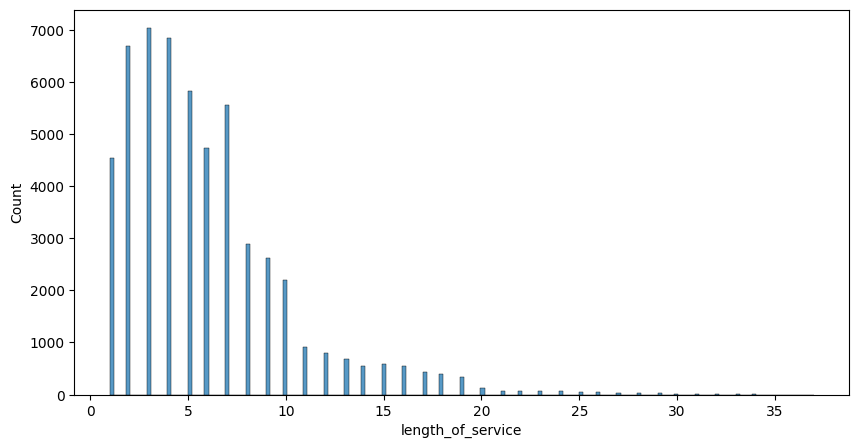

In [37]:
sns.histplot(data = data_hr_train_num_imputed2, x = 'length_of_service')
plt.show()

In [38]:
data_hr_train_num_imputed2.describe(percentiles = [0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329429,5.865512,0.351974,0.023172,63.386750
std,0.609264,7.660169,1.230352,4.265094,0.477590,0.150450,13.371559
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
90%,2.000000,46.000000,5.000000,11.000000,1.000000,0.000000,83.000000
95%,2.000000,51.000000,5.000000,15.000000,1.000000,0.000000,86.000000
97.5%,3.000000,55.000000,5.000000,17.000000,1.000000,0.000000,88.000000
99%,4.000000,58.000000,5.000000,20.000000,1.000000,1.000000,91.000000


### Consolidación

In [39]:
data_hr_train_cat_dummies2.head()

,Bachelor's,Below Secondary,Master's & above,f,m,other,referred,sourcing
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [40]:
data_hr_train_num_imputed2.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,1.0,35.0,5.0,8.0,1.0,0.0,49.0
1,1.0,30.0,5.0,4.0,0.0,0.0,60.0
2,1.0,34.0,3.0,7.0,0.0,0.0,50.0
3,2.0,39.0,1.0,10.0,0.0,0.0,50.0
4,1.0,45.0,3.0,2.0,0.0,0.0,73.0


In [41]:
data_hr_train_cat_dummies2.shape

(54808, 8)

In [42]:
data_hr_train_num_imputed2.shape

(54808, 7)

In [43]:
data_hr_train_total = pd.concat([data_hr_train_cat_dummies2, data_hr_train_num_imputed2], axis = 1)
data_hr_train_total.head()

,Bachelor's,Below Secondary,Master's & above,f,m,other,referred,sourcing,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,35.0,5.0,8.0,1.0,0.0,49.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,30.0,5.0,4.0,0.0,0.0,60.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,34.0,3.0,7.0,0.0,0.0,50.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,39.0,1.0,10.0,0.0,0.0,50.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,45.0,3.0,2.0,0.0,0.0,73.0


In [44]:
data_hr_train_total.isnull().sum()

Bachelor's              0
Below Secondary         0
Master's & above        0
f                       0
m                       0
other                   0
referred                0
sourcing                0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

### Estandarización

In [45]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [46]:
data_scaled = scaler.fit_transform(data_hr_train_total)

In [47]:
columnas = data_hr_train_total.columns
columnas

Index(['Bachelor's', 'Below Secondary', 'Master's & above', 'f', 'm', 'other',
       'referred', 'sourcing', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'KPIs_met >80%',
       'awards_won?', 'avg_training_score'],
      dtype='object')

In [48]:
data_hr_train_scaled = pd.DataFrame(data = data_scaled, columns = columnas)
data_hr_train_scaled[target]= data_target_train.values
data_hr_train_scaled.head()

,Bachelor's,Below Secondary,Master's & above,f,m,other,referred,sourcing,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.375,1.0,0.194444,1.0,0.0,0.166667,0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.250,1.0,0.083333,0.0,0.0,0.350000,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.350,0.5,0.166667,0.0,0.0,0.183333,0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.111111,0.475,0.0,0.250000,0.0,0.0,0.183333,0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.625,0.5,0.027778,0.0,0.0,0.566667,0


## Repetir todo el preprocesamiento para el conjunto de validación

In [122]:
data_hr_test = pd.read_csv('data/test.csv')

In [123]:
data_hr_test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [124]:
employee_id = data_hr_test[id_column]
data_hr_test = data_hr_test.drop(id_column, axis = 1)
data_hr_test = data_hr_test.drop('department', axis = 1)
data_hr_test = data_hr_test.drop('region', axis = 1)

In [125]:
data_hr_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   education             22456 non-null  object 
 1   gender                23490 non-null  object 
 2   recruitment_channel   23490 non-null  object 
 3   no_of_trainings       23490 non-null  int64  
 4   age                   23490 non-null  int64  
 5   previous_year_rating  21678 non-null  float64
 6   length_of_service     23490 non-null  int64  
 7   KPIs_met >80%         23490 non-null  int64  
 8   awards_won?           23490 non-null  int64  
 9   avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 1.8+ MB


In [126]:
data_hr_test_cat = data_hr_test.select_dtypes('object')
data_hr_test_num = data_hr_test.select_dtypes('number')

Imputación de nulos

In [127]:
# TODO: imputar las variables numéricas con KNN Imputer - interpretar los resultados

knn.fit_transform(data_hr_test_num)

array([[ 1.        , 24.        ,  4.        , ...,  1.        ,
         0.        , 77.        ],
       [ 1.        , 31.        ,  3.        , ...,  0.        ,
         0.        , 51.        ],
       [ 1.        , 31.        ,  1.        , ...,  0.        ,
         0.        , 47.        ],
       ...,
       [ 1.        , 26.        ,  4.        , ...,  0.        ,
         0.        , 50.        ],
       [ 3.        , 27.        ,  2.33333333, ...,  0.        ,
         0.        , 70.        ],
       [ 3.        , 40.        ,  5.        , ...,  1.        ,
         0.        , 89.        ]])

In [128]:
data_hr_test_num_imputed = pd.DataFrame(data = knn.fit_transform(data_hr_test_num), columns = data_hr_test_num.columns)

In [129]:
data_hr_test_num_imputed.isnull().sum()

no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

Categóricas

In [130]:
data_hr_test_cat_imputed = pd.DataFrame(imputer_cat.transform(data_hr_test_cat), columns = data_hr_test_cat.columns)
data_hr_test_cat_imputed.head()

,education,gender,recruitment_channel
0,Bachelor's,m,sourcing
1,Bachelor's,f,other
2,Bachelor's,m,other
3,Bachelor's,f,other
4,Bachelor's,m,sourcing


In [131]:
data_hr_test_cat_imputed.isnull().sum()

education              0
gender                 0
recruitment_channel    0
dtype: int64

Encoding

In [132]:
ohe.fit(data_hr_test_cat_imputed)
columnas = list(ohe.categories_[0])+list(ohe.categories_[1])+list(ohe.categories_[2])
ohe.transform(data_hr_test_cat_imputed).toarray()
data_hr_test_cat_dummies = pd.DataFrame(data = ohe.transform(data_hr_test_cat_imputed).toarray(), columns = columnas)

In [133]:
data_hr_test_total = pd.concat([data_hr_test_cat_dummies, data_hr_test_num_imputed], axis = 1)

In [145]:
data_hr_test_scaled = pd.DataFrame(data = scaler.fit_transform(data_hr_test_total), columns = data_hr_test_total.columns)

In [135]:
data_hr_train_scaled.head()

,Bachelor's,Below Secondary,Master's & above,f,m,other,referred,sourcing,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.375,1.0,0.194444,1.0,0.0,0.166667,0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.250,1.0,0.083333,0.0,0.0,0.350000,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.350,0.5,0.166667,0.0,0.0,0.183333,0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.111111,0.475,0.0,0.250000,0.0,0.0,0.183333,0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.625,0.5,0.027778,0.0,0.0,0.566667,0


In [136]:
data_hr_test_scaled.head()

,Bachelor's,Below Secondary,Master's & above,f,m,other,referred,sourcing,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00,0.100,0.75,0.000000,1.0,0.0,0.633333
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.00,0.275,0.50,0.121212,0.0,0.0,0.200000
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,0.275,0.00,0.090909,0.0,0.0,0.133333
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.25,0.275,0.25,0.242424,0.0,0.0,0.433333
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00,0.250,0.75,0.181818,0.0,0.0,0.366667


In [137]:
data_hr_train_scaled.shape

(54808, 16)

In [138]:
data_hr_test_scaled.shape ## PREDICCIÓN REAL

(23490, 15)

In [66]:
X = data_hr_train_scaled.drop(target, axis =1)
y = data_hr_train_scaled[target]
# función para dividir la base en piloto y control
from sklearn.model_selection import train_test_split
# usaremos la división train/test en 80/20. Otro ratio recomendable es 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = seed)

### Regresion Logistica Binaria

In [87]:
# Paso N°01: Elegimos y entrenamos un algoritmo de ML
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model_lr = lr.fit(X_train,y_train) # Entrenamiento!
# Paso N°02: Con el algoritmo entrenado predecimos sobre la data de train y test!

y_pred_train=lr.predict(X_train) # Prediccion sobre el train
y_pred_test= lr.predict(X_test) # Prediccion sobre el test

y_proba_test= lr.predict_proba(X_test)[:,1]   #Prediccion de probabilidades del target

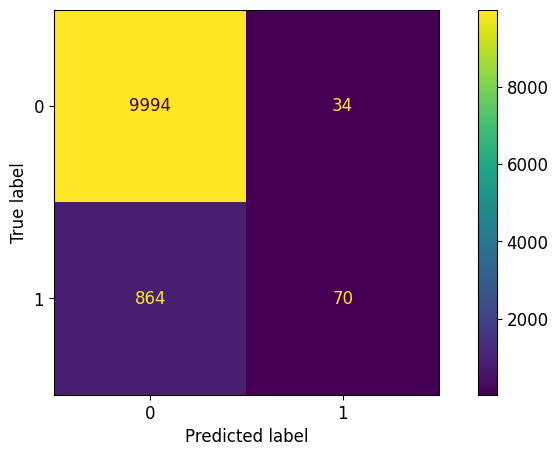

In [88]:
# Paso N°03: Revisamos las metricas de validación!
from sklearn import metrics as metrics

# Mostrando la matriz de confusión para el conjunto de test
cm = metrics.confusion_matrix(y_test,y_pred_test, labels=lr.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr.classes_)
disp.plot()
plt.show()

In [89]:
from sklearn.metrics import classification_report

print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10028
           1       0.67      0.07      0.13       934

    accuracy                           0.92     10962
   macro avg       0.80      0.54      0.55     10962
weighted avg       0.90      0.92      0.89     10962



In [90]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(y, y_proba, label = ''):
    '''
    dibujar la curva roc para las probabilidades y target entregados
    
    params:
    y: etiquetas originales
    y_proba: probabilidades resultado del modelo
    '''
    
    auc_roc = roc_auc_score(y, y_proba)
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    
    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 12})
    plt.plot(fpr, fpr, c = 'red')
    plt.plot(fpr, tpr, label= (f"Curva ROC {label} (AUC = {auc_roc:.4f})"))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"Curva ROC {label}")
    plt.legend(loc=4, numpoints=1)

In [91]:
# ROC AUC
roc_auc_score(y_test, y_proba_test)

0.8072213647611101

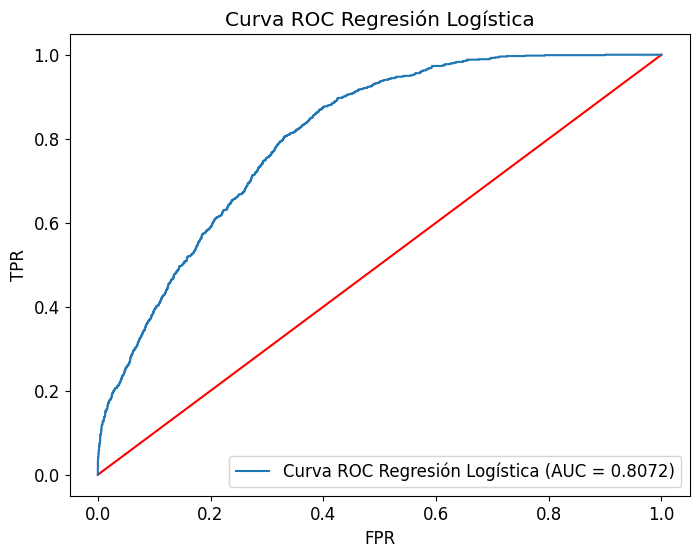

In [92]:
# Gráfica Curva ROC
plot_roc_curve(y_test, y_proba_test, 'Regresión Logística')

Árbol de decisión

In [93]:
from matplotlib import pyplot as plt # Para graficar las desición del arbol
from sklearn import datasets #El dataset que usara
from sklearn.tree import DecisionTreeClassifier # El algoritmo para usar arbol
from sklearn import tree #Arbol
clf = DecisionTreeClassifier(random_state=2) #Instanciar el objeto
#Paso 2 : Fit con la información
model_dt = clf.fit(X_train, y_train)
#Paso 3 : Predicción
pred = model_dt.predict(X_test)

In [94]:
from sklearn.metrics import classification_report

print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10028
           1       0.27      0.33      0.30       934

    accuracy                           0.87     10962
   macro avg       0.60      0.62      0.61     10962
weighted avg       0.88      0.87      0.87     10962



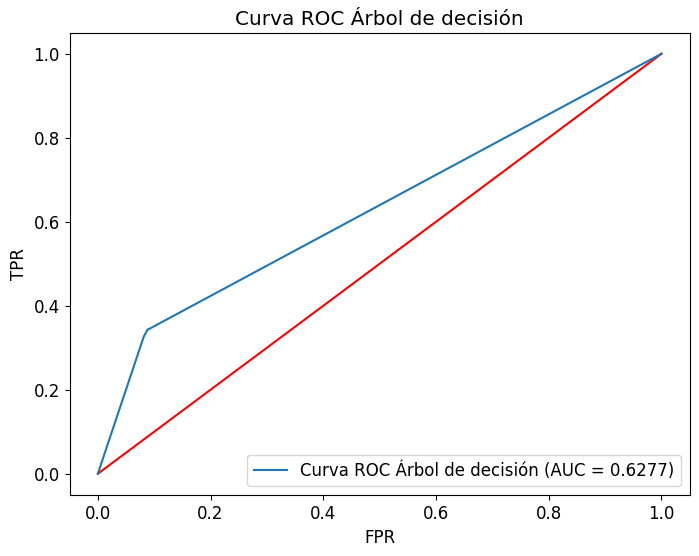

In [95]:
# Gráfica Curva ROC
y_proba_test= model_dt.predict_proba(X_test)[:,1]   #Prediccion de probabilidades del target
plot_roc_curve(y_test, y_proba_test, 'Árbol de decisión')

Naive Bayes

In [101]:

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
model_gnb = gnb.fit(X_train, y_train)
pred_gnb=model_gnb.predict(X_test)

In [102]:
from sklearn.metrics import classification_report

print(metrics.classification_report(y_test, pred_gnb))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10028
           1       0.32      0.17      0.22       934

    accuracy                           0.90     10962
   macro avg       0.62      0.57      0.58     10962
weighted avg       0.87      0.90      0.88     10962



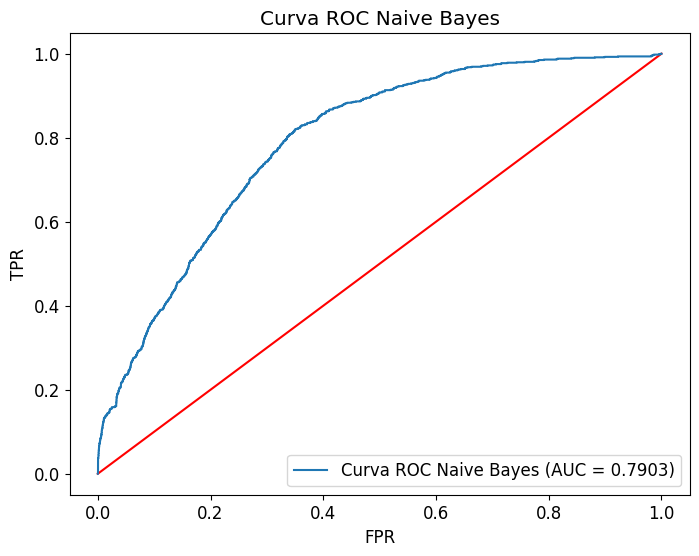

In [103]:
# Gráfica Curva ROC
y_proba_test= model_gnb.predict_proba(X_test)[:,1]   #Prediccion de probabilidades del target
plot_roc_curve(y_test, y_proba_test, 'Naive Bayes')

Random Forest

In [139]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=25, random_state=0)
model_rfc = rfc.fit(X_train, y_train)
pred_rfc = model_rfc.predict(X_test)

In [140]:
from sklearn.metrics import classification_report

print(metrics.classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     10028
           1       0.58      0.20      0.30       934

    accuracy                           0.92     10962
   macro avg       0.76      0.59      0.63     10962
weighted avg       0.90      0.92      0.90     10962



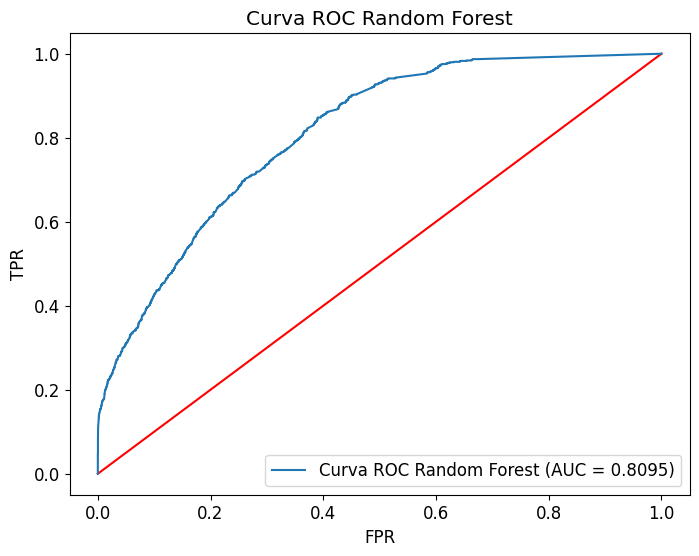

In [141]:
# Gráfica Curva ROC
y_proba_test= model_rfc.predict_proba(X_test)[:,1]   #Prediccion de probabilidades del target
plot_roc_curve(y_test, y_proba_test, 'Random Forest')

In [146]:
pred_proba_svc= model_rfc.predict_proba(data_hr_test_scaled)[:,1]   #Prediccion de probabilidades del target
pred_final_svc= model_rfc.predict(data_hr_test_scaled)

In [147]:
data_hr_test_scaled.insert(0, id_column, employee_id)
data_hr_test_scaled.insert(1, 'prob_is_promoted', pred_proba_svc)
data_hr_test_scaled.insert(2, target, pred_final_svc)
data_hr_test_scaled.head()

,employee_id,prob_is_promoted,is_promoted,Bachelor's,Below Secondary,Master's & above,f,m,other,referred,sourcing,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,0.043504,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00,0.100,0.75,0.000000,1.0,0.0,0.633333
1,74430,0.000000,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.00,0.275,0.50,0.121212,0.0,0.0,0.200000
2,72255,0.000000,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.00,0.275,0.00,0.090909,0.0,0.0,0.133333
3,38562,0.010000,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.25,0.275,0.25,0.242424,0.0,0.0,0.433333
4,64486,0.010923,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00,0.250,0.75,0.181818,0.0,0.0,0.366667


In [148]:
data_hr_test_scaled[target].value_counts()

0    22832
1      658
Name: is_promoted, dtype: int64